Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

### Load Libraries

In [1]:
# Load libraries


# from sklearn import metrics as mt
# from sklearn.metrics import plot_confusion_matrix, roc_auc_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# import warnings
# warnings.simplefilter('ignore', DeprecationWarning)
# from sklearn.model_selection import cross_validate
# from sklearn.pipeline import Pipeline
# from collections import Counter
# from imblearn.over_sampling import SMOTE
# import seaborn as sns
# from sklearn.naive_bayes import ComplementNB
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import RFECV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from mlxtend.evaluate import paired_ttest_5x2cv

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import time
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import OPTICS
import random

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

### Sub-Section 1.1: Load in and Prepare Data

#### Read in data

In [2]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

The final predictor data set contains 33 attributes and 79,423 instances. The data set contains 8 coninuous attributes and 25 binary attributes created from one-hot encoding. The response sets for Won and Show each contain 79,423 instances as well. The descriptive statistics for each predictor are listed above. You can see that all one-hot encoded predictors have a min of 0 and max of 1 since these are binary variables. All other continuous variables do not appear to have any concerning outliers when looking at the min and max values.

Remaining original continuous features contained in the runs_data set:
- Horse_no - the number assigned to this horse, in the race
- Horse_age: all horses in the data set are 2, 3, 4, 5, 6, 7, 8, 9, or 10 years old at the time of race. The average age of horses in the dataset is 3.3 years
- Horse_rating - rating number assigned by HKJC to this horse at the time of the race
- Declared_weight: floating point value for the weight of the horse, the jockey, and the equipment in pounds.
- Actual_weight: integer value for the weight the horse carried; i.e. the weight of the Jockey and equipment
- Draw - post position number of the horse in this race
- Win_odds: floating point value for the odds of the horse to win the race
- Place_odds: floating point value for the odds of the horse to place in 1st, 2nd, or 3rd

Remaining original categorical features contained in the runs_data set that were one-hot encoded:
- Horse_country: a country code for the country of origin for the horse. Examples are NZ, AUS, USA
- Horse_type: examples are gelding, mare, rig

Response Variables:
- Won: a boolean value where 1 indicates the horse finished first in the race and 0 indicates the horse did not. A horse with a Result of 1 will have a Won response of 1. All others will have a Won response of 0.
- Show: a boolean value where 1 indicates the horse placed in the top 3 of the race and 0 indicates the horse did not. A horse with a Result of 1, 2, or 3 will have a Show response of 1. All others will have a Show response of 0.

*Show is the one new variable created from the original set*


#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
print('Won Response Set Shape: ',runs_target.shape)
print('Show Response Set Shape: ',runs_target2.shape)
runs_data.info()
runs_data.describe()

Won Response Set Shape:  (79423,)
Show Response Set Shape:  (79423,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            79423 non-null  int64  
 1   horse_age           79423 non-null  int64  
 2   horse_rating        79423 non-null  int64  
 3   declared_weight     79423 non-null  float64
 4   actual_weight       79423 non-null  int64  
 5   draw                79423 non-null  int64  
 6   win_odds            79423 non-null  float64
 7   place_odds          79423 non-null  float64
 8   horse_country_ARG   79423 non-null  uint8  
 9   horse_country_AUS   79423 non-null  uint8  
 10  horse_country_BRZ   79423 non-null  uint8  
 11  horse_country_CAN   79423 non-null  uint8  
 12  horse_country_FR    79423 non-null  uint8  
 13  horse_country_GB    79423 non-null  uint8  
 14  horse_country_GER   79423 non-nul

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,6.905644,3.339461,61.035103,1104.952609,122.730091,6.875729,28.806138,7.421841,0.001599,0.376415,...,0.000151,0.025736,0.003840,0.000541,0.950367,0.000214,0.013762,0.002997,0.001939,0.000604
std,3.760600,0.876864,11.750531,62.350596,6.305551,3.747588,30.093854,8.613459,0.039956,0.484489,...,0.012291,0.158346,0.061851,0.023262,0.217187,0.014629,0.116501,0.054660,0.043991,0.024576
min,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,60.000000,1062.000000,118.000000,4.000000,7.700000,2.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,15.000000,4.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,3.000000,60.000000,1146.000000,128.000000,10.000000,38.000000,8.200000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,99.000000,101.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Create Cross-Validation and Single Train/Test Sets

In [7]:
cv = StratifiedKFold(n_splits = 10, shuffle = True ,random_state = 0)

In [8]:
# training test split for showing confusion matrix
# Note all evaluation will actually use kFold CrossValidation

#train test split won
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

#train test split place
X_train_place,X_test_place,Y_train_place,Y_test_place = train_test_split(runs_data,runs_target2,test_size=0.20,random_state=0)
mmscl_obj = MinMaxScaler()
X_train_place = mmscl_obj.fit_transform(X_train_place,y = None)
X_test_place = mmscl_obj.transform(X_test_place)

## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

## Section 4: Modeling and Evaluation 1

Train and adjust parameters

### Cluster 1 Batch and Mini-Batch K-means of Win Odds and Place Odds

Time for BatchKMeans:
CPU times: user 3.43 s, sys: 696 ms, total: 4.13 s
Wall time: 1.37 s
Time for MiniBatchKMeans:
CPU times: user 981 ms, sys: 81.8 ms, total: 1.06 s
Wall time: 719 ms


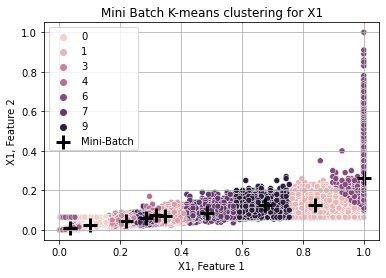

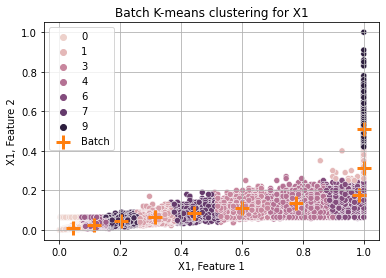

In [9]:
win_place_train=X_train[:,[6,7]] #Create an array with win odds, place odds

kmeans_mini = MiniBatchKMeans(n_clusters=10, batch_size=10,random_state=0)
kmeans = KMeans(n_clusters=10,random_state=0)

print('Time for BatchKMeans:')
%time kmeans.fit(win_place_train)
print('Time for MiniBatchKMeans:')
%time kmeans_mini.fit(win_place_train)

# visualize the data
c_mini=kmeans_mini.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_mini)
centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('Mini Batch K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

c_means=kmeans.labels_
sns.scatterplot(win_place_train[:, 0], win_place_train[:, 1], hue=c_means)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids
plt.legend()
plt.title('Batch K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

Time for BatchKMeans:
CPU times: user 4.49 s, sys: 832 ms, total: 5.32 s
Wall time: 1.67 s
Time for MiniBatchKMeans:
CPU times: user 943 ms, sys: 119 ms, total: 1.06 s
Wall time: 951 ms


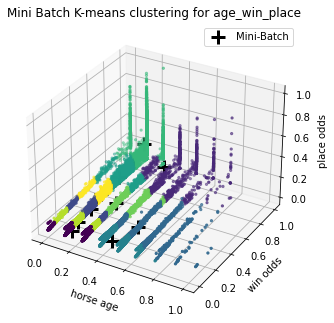

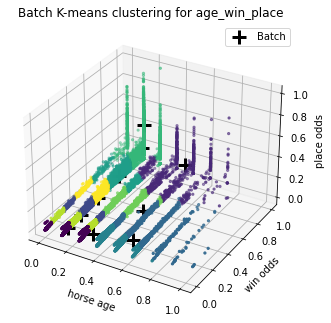

In [10]:
age_win_place_train=X_train[:,[1,6,7]] #Create an array with win odds, place odds

kmeans_mini = MiniBatchKMeans(n_clusters=10, batch_size=10,random_state=0)
kmeans = KMeans(n_clusters=10,random_state=0)

print('Time for BatchKMeans:')
%time kmeans.fit(age_win_place_train)
print('Time for MiniBatchKMeans:')
%time kmeans_mini.fit(age_win_place_train)

# visualize the data
fig = plt.figure()
ax = Axes3D(fig)

c_mini=kmeans_mini.labels_
ax.scatter(age_win_place_train[:,0], age_win_place_train[:,1], age_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans_mini.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch',depthshade=False)  # plot the centroids
ax.legend()
plt.title('Mini Batch K-means clustering for age_win_place')
plt.xlabel('horse age')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

fig = plt.figure()
ax = Axes3D(fig)

c_means=kmeans.labels_
ax.scatter(age_win_place_train[:,0], age_win_place_train[:,1], age_win_place_train[:,2],c=c_mini,s=5)
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2],
            marker='+', s=200, linewidths=3, color='k',label='Batch',depthshade=False)  # plot the centroids
ax.legend()
plt.title('Batch K-means clustering for age_win_place')
plt.xlabel('horse age')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

In [11]:
print('Batch objective function value:', kmeans.inertia_)
print('Mini-Batch objective function value:', kmeans_mini.inertia_)

Batch objective function value: 355.48555616085946
Mini-Batch objective function value: 462.3329096223529


We can see that Batch has a much lower inertia and therefore is a better approximation of clusters

### Cluster 2

In [12]:
age_win_place_train=X_train[:,[1,6,7]] #Create an array with win odds, place odds, and horse age
age_draw_place_train=X_train[:,[1,5,7]] #Create an array with win odds, place odds, and horse age
dweight_aweight_place_train=X_train[:,[3,4,7]] #Create an array with win odds, place odds, and horse age

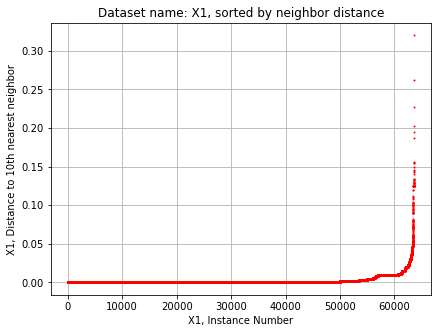

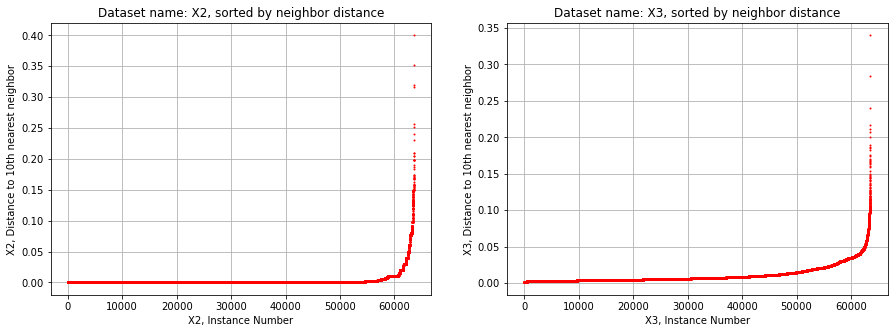

In [13]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors

X1=age_win_place_train
X2=age_draw_place_train
X3=dweight_aweight_place_train

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X1_N = 10
X2_N = 10
X3_N = 10
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N1 = X1_knn_graph.shape[0]
X1_4nn_distances = np.zeros((N1,1))
for i in range(N1):
    X1_4nn_distances[i] = X1_knn_graph[i,:].max()

X1_4nn_distances = np.sort(X1_4nn_distances, axis=0)

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N3):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N1), X1_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X1, sorted by neighbor distance')
plt.xlabel('X1, Instance Number')
plt.ylabel('X1, Distance to {0}th nearest neighbor'.format(X1_N))
plt.grid()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

In [14]:
# #=====================================
# # ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
# X1_minpts = X1_N # from above
# X1_eps = 0.01
# X2_minpts = X2_N # from above
# X2_eps = 0.01
# X3_minpts = X3_N # from above
# X3_eps = 0.025
# #=====================================

# for i, (data, minpts, eps) in enumerate(zip([X1,X2,X3],[X1_minpts,X2_minpts,X3_minpts],[X1_eps,X2_eps,X3_eps])):

#     db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
#     labels = db.labels_

#     # Number of clusters in labels, ignoring noise if present.
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#     # mark the samples that are considered "core"
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True

#     plt.figure(figsize=(15,4))
#     unique_labels = set(labels) # the unique labels
#     colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = 'k'

#         class_member_mask = (labels == k)

#         xy = data[class_member_mask & core_samples_mask]
#         ax = Axes3D(fig)
#         ax.scatter(xy[:, 0], xy[:, 1], xy[:,2], hue=col)

#         # plot the remaining points that are edge points
#         xy = data[class_member_mask & ~core_samples_mask]
#         ax.scatter(xy[:, 0], xy[:, 1], xy[:,2], hue=col)

#     plt.title('Estimated number of clusters: %d' % n_clusters_)
#     plt.grid()
#     plt.show()

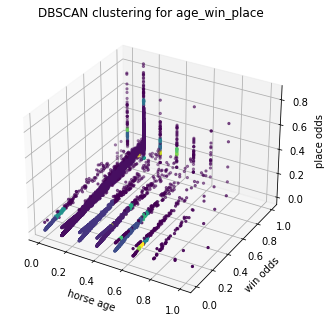

number of cluster found:  27


In [15]:
# X1=age_win_place_train
# X2=age_draw_place_train
# X3=dweight_aweight_place_train
X=X1
X_minpts = X1_N # from above
X_eps = 0.015

random.seed(0)
np.random.shuffle(X)
X = X[:15000,:]

model = DBSCAN(eps=X_eps, min_samples=X_minpts)
model.fit_predict(X)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=5)
plt.title('DBSCAN clustering for age_win_place')
plt.xlabel('horse age')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of cluster found: ", len(set(model.labels_)))

/Users/Camo/opt/anaconda3/envs/py37_r/lib/python3.7/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/Users/Camo/opt/anaconda3/envs/py37_r/lib/python3.7/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


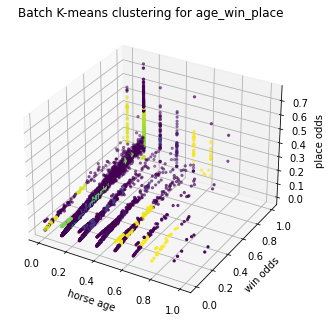

number of cluster found:  246


In [16]:
# X1=age_win_place_train
# X2=age_draw_place_train
# X3=dweight_aweight_place_train
X=X1
X_minpts = X1_N # from above
X_eps = 0.02

random.seed(0)
np.random.shuffle(X)
X = X[:10000,:]

model = OPTICS(eps=X_eps, min_samples=X_minpts)
model.fit_predict(X)
pred = model.fit_predict(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=model.labels_, s=5)
plt.title('Batch K-means clustering for age_win_place')
plt.xlabel('horse age')
plt.ylabel('win odds')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('place odds', rotation=90)
plt.show()

print("number of cluster found: ", len(set(model.labels_)))

### Cluster 3

### Cluster 4

...

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...